In [9]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from typing import List, Union

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import os
import sys
import contextlib

import pandas as pd

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

COLORS = ['#1b9e77', '#d95f02', '#7570b3']  # teal, orange, purple
DATA_DIR = '/glade/u/home/fcottier/d4-columbia-hurricane-migration/contributors/fcottier'

In [10]:
inputDS=DATA_DIR + os.sep + 'df_migration_hurricane.csv'

inputDF=pd.read_csv(inputDS)
inputDF.columns

Index(['GEOID', 'year', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER',
       'nInMigr', 'nOutMigr', 'netMigr', 'avg_gustW_peak', 'avg_sustW_max',
       'max_gustW_peak', 'max_sustW_max', 'TotalResLoss', 'BuildingLoss',
       'EmpLoss', 'pop_2000', 'medIncHH_2000', 'povertyL_2000', 'unempl_2000',
       'ownerL_2000', 'afroAmerL_2000', 'rural_L_2000', 'SVI_2000', 'INLECZ',
       'nOutMigr_ln', 'nInMigr_ln', 'TP2000L05_L', 'TP2000L10_L',
       'avg_gustW_peak_1l', 'avg_sustW_max_1l', 'max_gustW_peak_1l',
       'max_sustW_max_1l', 'TotalResLoss_1l', 'BuildingLoss_1l', 'EmpLoss_1l',
       'avg_gustW_peak_2l', 'avg_sustW_max_2l', 'max_gustW_peak_2l',
       'max_sustW_max_2l', 'TotalResLoss_2l', 'BuildingLoss_2l', 'EmpLoss_2l',
       'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007',
       'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year

In [11]:
# variables correction
inputDF['pop_2000_ln'] = np.log(inputDF['pop_2000'])
inputDF['nOutMigr_ln'] = np.log(inputDF['nOutMigr'] + 1)

In [12]:
inputDF = inputDF.query('year > 2002')
Xp=inputDF[['avg_gustW_peak_1l', 'avg_sustW_max_1l',
       'pop_2000_ln', 'SVI_2000', 'rural_L_2000',  'INLECZ']]
T = inputDF[['GEOID', 'year',"netMigr"]]
print(f'{Xp.shape=}, {T.shape=}')

Xp.shape=(5339, 6), T.shape=(5339, 3)


In [13]:
#T["nOutMigr_ln"]=T.groupby("GEOID")["nOutMigr_ln"].transform(lambda x:x-x.mean())
T["netMigr"]=T["netMigr"].transform(lambda x:(x-x.mean()))
tMean = T["netMigr"].mean()
                                            



/glade/derecho/scratch/fcottier/tmp/ipykernel_36998/4140411529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T["netMigr"]=T["netMigr"].transform(lambda x:(x-x.mean()))


In [14]:
# standardize X
Xp = (Xp - Xp.mean(axis=0)) / Xp.std(axis=0)
#Xp

In [15]:
Xp = pd.concat([inputDF[['GEOID', 'year']],Xp],axis=1)
Xp

,GEOID,year,avg_gustW_peak_1l,avg_sustW_max_1l,pop_2000_ln,SVI_2000,rural_L_2000,INLECZ
1,1001,2003,-0.250596,-0.250579,0.004534,0.087675,-0.309377,-0.83839
2,1001,2004,-0.250596,-0.250579,0.004534,0.087675,-0.309377,-0.83839
3,1001,2005,3.475555,3.463877,0.004534,0.087675,-0.309377,-0.83839
4,1001,2006,2.621846,2.631185,0.004534,0.087675,-0.309377,-0.83839
5,1001,2007,-0.250596,-0.250579,0.004534,0.087675,-0.309377,-0.83839
...,...,...,...,...,...,...,...,...
5615,48507,2017,-0.250596,-0.250579,-1.026303,1.764819,-0.546977,-0.83839
5616,48507,2018,-0.250596,-0.250579,-1.026303,1.764819,-0.546977,-0.83839
5617,48507,2019,-0.250596,-0.250579,-1.026303,1.764819,-0.546977,-0.83839
5618,48507,2020,-0.250596,-0.250579,-1.026303,1.764819,-0.546977,-0.83839


In [17]:
def partition(X: np.ndarray, T: np.ndarray) -> Union[List[np.ndarray], List[np.ndarray]]:
    #if shuffle
    #    rng = np.random.default_rng(seed)
    #    indices = rng.permutation(X.shape[0])
    #    X, T = X[indices], T[indices]
   
    #train_end = int(Xp.shape[0] * train_fraction)

    # if validation_fraction > 0:
    #     valid_end = train_end + int(X.shape[0] * validation_fraction)
    #     Xtrain, Xvalid, Xtest = X[:train_end], X[train_end:valid_end], X[valid_end:]
    #     Ttrain, Tvalid, Ttest = T[:train_end], T[train_end:valid_end], T[valid_end:]
    #     return Xtrain, Ttrain, Xvalid, Tvalid, Xtest, Ttest
    # else:
    #     Xtrain, Xtest = X[:train_end], X[train_end:]
    #     Ttrain, Ttest = T[:train_end], T[train_end:]


    Xtrain=X.query('year<2018').drop(['GEOID','year'],axis=1)
    Xtest=X.query('year>=2018').drop(['GEOID','year'],axis=1)
    Ttrain=T.query('year<2018').drop(['GEOID','year'],axis=1)
    Ttest=T.query('year>=2018').drop(['GEOID','year'],axis=1)
    idTrain=X.query('year<2018')[['GEOID','year']]
    idTest=X.query('year>=2018')[['GEOID','year']]
    return Xtrain, Ttrain, Xtest, Ttest, idTrain, idTest
   
Xtrain, Ttrain, Xtest, Ttest, idTrain, idTest = partition(Xp, T)
print(f'{Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}, {idTrain.shape=}, {idTest.shape=}')


Xtrain.shape=(4215, 6), Ttrain.shape=(4215, 1), Xtest.shape=(1124, 6), Ttest.shape=(1124, 1), idTrain.shape=(4215, 2), idTest.shape=(1124, 2)


In [18]:
# evaluation

def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

def r2(T, Y):
    ss_res = np.sum((T - Y) ** 2)
    ss_tot = np.sum((T - np.mean(T)) ** 2)
    return 1 - (ss_res / ss_tot)

# !plotting
def plot_evaluation(T, Y):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.plot(T, Y, 'o', alpha=0.20, markersize=3, color='k')
    ax.plot([T.min(), T.max()], [T.min(), T.max()], 'b', lw=2.5)
    ax.set_xlabel('Observed migration')
    ax.set_ylabel('Predicted migration')
    ax.set_title(f'RMSE: {rmse(T, Y):.3f}, R$^2$: {r2(T, Y):.3f}', loc='right')
    fig.tight_layout()

In [19]:
### TO DO: CORRECT NO LONGER ERRO
#Ttrain.replace([np.inf, -np.inf], np.nan, inplace=True)
#Ttrain = Ttrain.fillna(0)

In [20]:
# random forest preparation
Xtrain = Xtrain.to_numpy()
Xtest = Xtest.to_numpy()
Ttrain = Ttrain.to_numpy().ravel()
Ttest = Ttest.to_numpy().ravel()
print(f'{Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

Xtrain.shape=(4215, 6), Ttrain.shape=(4215,), Xtest.shape=(1124, 6), Ttest.shape=(1124,)


In [21]:
params = {
    'n_estimators': 20,      # number of trees in the forest
    'max_depth': 5,          # maximum depth of each tree
    'min_samples_split': 2,   # minimum number of samples required to split an internal node
    'min_samples_leaf': 1,    # minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',   # number of features to consider when looking for the best split
    'bootstrap': True,        # whether bootstrap samples are used when building trees
    'random_state': 42,       # seed for reproducibility
    'n_jobs': -1              # use all available cores for parallel processing
}

model = RandomForestRegressor(**params)
model.fit(Xtrain, Ttrain);

In [22]:
np.max(Ttest)

np.float64(12666.257351563963)

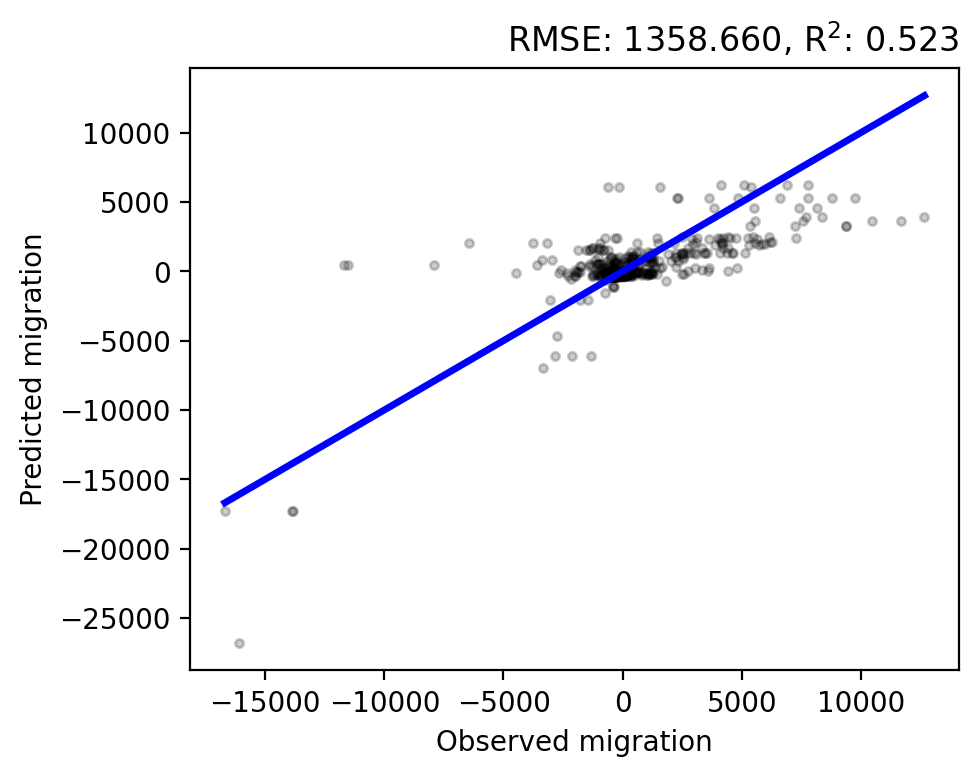

In [23]:
Ytest = model.predict(Xtest)
plot_evaluation(Ttest, Ytest)

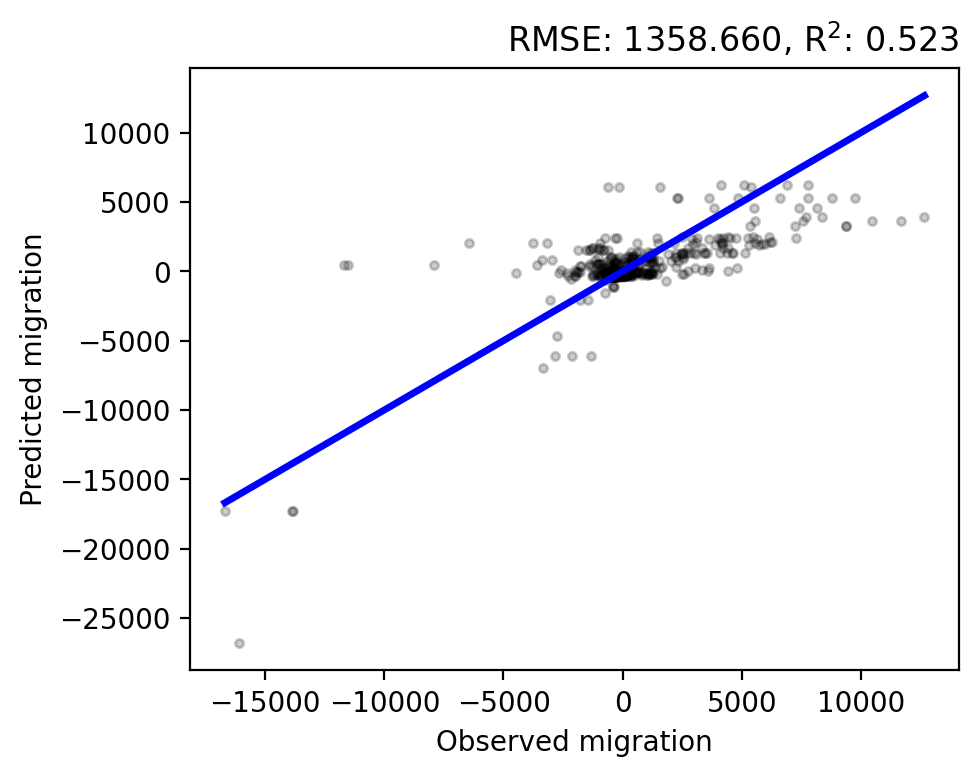

In [24]:
Ytest = model.predict(Xtest)
plot_evaluation(Ttest+tMean, Ytest+tMean)

In [27]:
Xp.columns

Index(['GEOID', 'year', 'avg_gustW_peak_1l', 'avg_sustW_max_1l', 'pop_2000_ln',
       'SVI_2000', 'rural_L_2000', 'INLECZ'],
      dtype='object')

/glade/derecho/scratch/fcottier/tmp/ipykernel_36998/4044041283.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


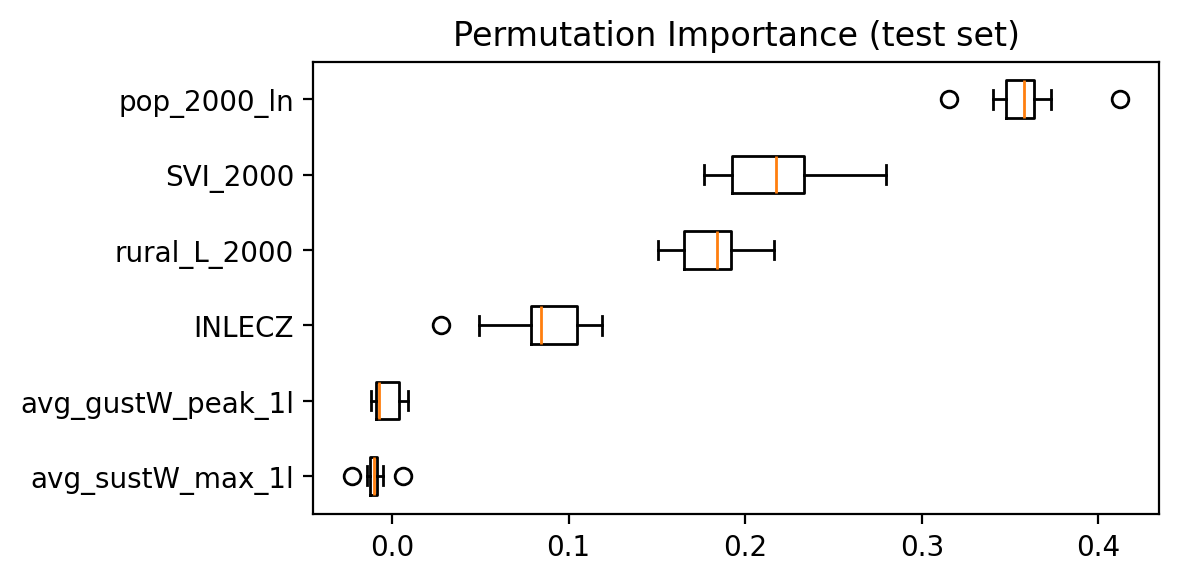

In [28]:
result = permutation_importance(
    model, Xtest, Ttest, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = np.argsort(result.importances_mean)

fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=(Xp.columns[2:8])[sorted_idx],
)
ax.set_title('Permutation Importance (test set)')
fig.tight_layout()

In [29]:
# boosting
params = {
    'n_estimators': 100,      # number of boosting stages to perform
    'learning_rate': 0.05,    # step size shrinkage
    'max_depth': 4,           # maximum depth of the individual estimators
    'min_samples_split': 10,  # minimum number of samples required to split an internal node
    'min_samples_leaf': 2,    # minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',   # number of features to consider when looking for the best split
    'subsample': 0.8,         # fraction of samples to be used for fitting the individual base learners
    'random_state': 42        # seed for reproducibility
}
model = GradientBoostingRegressor(**params)
model.fit(Xtrain, Ttrain);


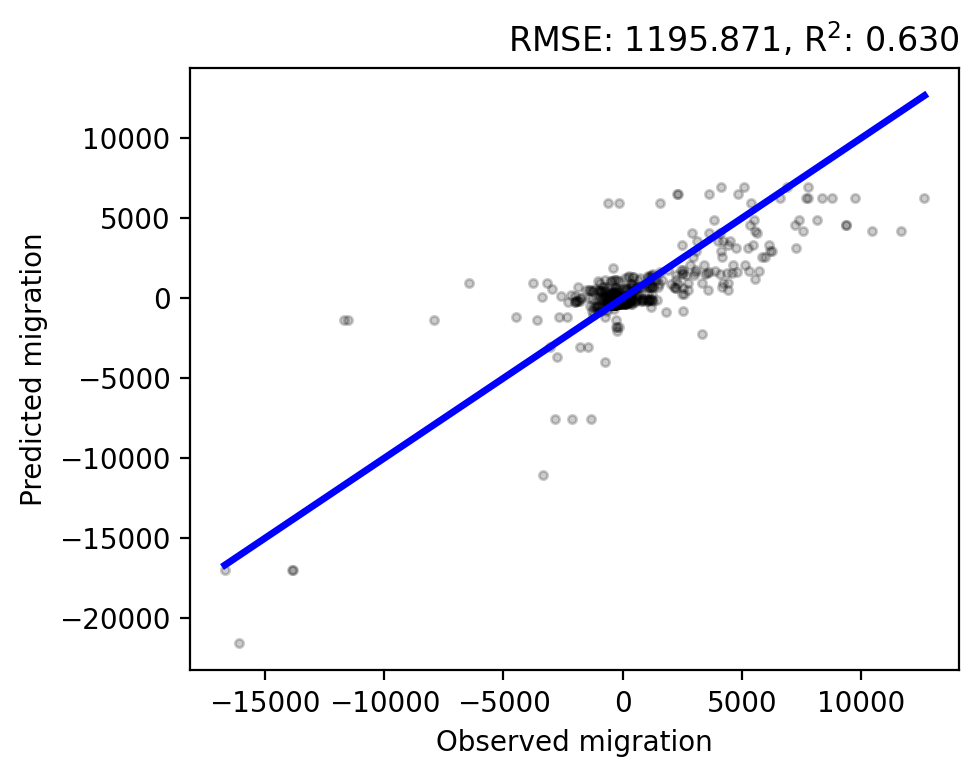

In [30]:
# plot performance
Ytest = model.predict(Xtest)
plot_evaluation(Ttest, Ytest)